In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

# choose the device that is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the target GMM
std_normal = MultivariateNormal(torch.zeros(2), torch.eye(2))
bimodal_mean1 = torch.tensor([2.0, 2.0])
bimodal_mean2 = torch.tensor([-2.0, -2.0])
bimodal_cov = 0.5 * torch.eye(2)

def sample_bimodal(n):
    z = torch.randint(0, 2, (n,))
    samples = torch.stack([
        MultivariateNormal(bimodal_mean1, bimodal_cov).sample((n,)),
        MultivariateNormal(bimodal_mean2, bimodal_cov).sample((n,))
    ], dim=1)
    return samples[torch.arange(n), z]

# Neural vector field f(x, t)
class VectorField(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=-1)
        return self.net(xt)

f = VectorField().to(device)
optimizer = optim.Adam(f.parameters(), lr=1e-3)

# Flow Matching training loop
def train_flow_matching(steps=5000, batch_size=256):
    for step in range(steps):
        t = torch.rand(batch_size, 1).to(device)  # time samples in [0, 1]
        x0 = std_normal.sample((batch_size,)).to(device)
        x1 = sample_bimodal(batch_size).to(device)

        # Linear interpolation
        xt = (1 - t) * x0 + t * x1

        # Oracle velocity (straight-line flow)
        v_target = x1 - x0

        # Predict vector field
        v_hat = f(xt, t)

        loss = torch.mean((v_hat - v_target) ** 2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 500 == 0:
            print(f"Step {step}, Loss: {loss.item():.4f}")

train_flow_matching()


Step 0, Loss: 5.7357
Step 500, Loss: 3.4386
Step 1000, Loss: 2.4824
Step 1500, Loss: 2.6600
Step 2000, Loss: 2.5883
Step 2500, Loss: 2.4347
Step 3000, Loss: 2.4863
Step 3500, Loss: 2.4906
Step 4000, Loss: 2.8118
Step 4500, Loss: 2.4592


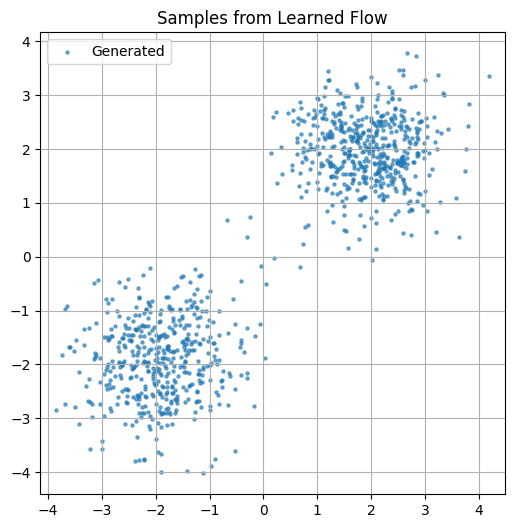

In [2]:
@torch.no_grad()
def sample_from_flow(n_samples=1000, steps=50):
    dt = 1.0 / steps
    x = std_normal.sample((n_samples,)).to(device)
    for i in range(steps):
        t = torch.full((n_samples, 1), i * dt).to(device)
        v = f(x, t)
        x = x + dt * v
    return x.cpu()

samples = sample_from_flow()

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.6, label="Generated")
plt.title("Samples from Learned Flow")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()
